# Long short term memory and Gated recurrent unit
This notebook implements two RNN technique Long short term memory (LSTM) and Gated recurrent unit (GRU). It is just for exploring the concept rather than aiming for a good results.

This is inspired by Dr Jorge Cardoso's lecture at King's College London.

## Import general library and define common structure

In [34]:
# Import library and set up environment
import os as os
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torch.optim as optim
import pandas as pd
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_workers = torch.cuda.device_count()
print("Number of GPU workers available:", num_workers)

cpu
Number of GPU workers available: 0


In [35]:
# Create a class that aid in training and testing
class Model_Wrapper:
    def __init__(self, model, optimizer, loss_function, device):
        '''Start the model and store important object'''
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.device = device
        self.total_train_epoch = 0
        self.train_loss_list = []
        self.calculated_metrics = None

    def push_to_device(self):
        self.model = self.model.to(self.device)
        self.loss_function = self.loss_function.to(self.device)

    def train(self, num_epochs, train_loader):
        '''Train model'''
        # Start training
        expected_total_epoch = self.total_train_epoch + num_epochs
        for epoch in range(num_epochs):
            self.model.train()
            for i, (input, output) in enumerate(train_loader, 0):
                # Push data to GPU, clear gradient, calculate loss, backpropagation
                input = input.to(self.device)
                output = output.to(self.device)
                # Zero gradient
                self.optimizer.zero_grad()
                # Forward
                result, _ = self.model(input)
                # Calculate the loss
                loss = self.loss_function(result, output)
                # Calculate the gradient
                loss.backward()
                # Update the weight
                self.optimizer.step()
                # Store the loss value
                self.train_loss_list.append(loss.item())
                # print the loss
                if i % 50 == 0:
                    print(f"Epoch: {self.total_train_epoch+1}/{expected_total_epoch}; Data {i*len(output)}/{len(train_loader.dataset)}; Loss: {loss.item()}")
            self.total_train_epoch += 1

    def plot_train_loss(self, plot_title = "Loss value during training"):
        """Plot the loss value during training"""
        # Add plot
        _, ax = plt.subplots()
        ax.plot(range(len(self.train_loss_list)), self.train_loss_list)
        # Add a title and labels
        ax.set_title(plot_title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Loss value')

    def test(self, test_loader):
        """Test on test data set"""
        total_loss=[]
        # Test the model
        self.model.eval()
        for i, (input, output) in enumerate(test_loader, 0):
            # Push data to GPU, predict, and calculate the loss
            input = input.to(device)
            output = output.to(device)
            # Predict
            result, _ = self.model(input)
            # Calculate the loss
            loss = self.loss_function(output, result)
            # Append the loss
            total_loss.append(loss.item())
            # Calculate performance
            self.calculate_metrics(result, output)
        # print the loss and metrics
        print(f"Loss: {round(np.array(total_loss).mean(),4)}")
        for metric_name, metric_value in self.calculated_metrics.items():
            print(metric_name, ": ", round(np.array(metric_value).mean(),4), sep="")

    def calculate_metrics(self, labels, output):
        """Edit here to calculate the metrics"""
        """Should be individualized"""
        # Make prediction
        if (self.calculated_metrics == None):
            self.calculated_metrics = {}

## Load and visualize data

In [36]:
import requests

url = "https://raw.githubusercontent.com/alfredoandere/ML/master/Project1_DOJ30/stock-time-series-20050101-to-20171231/IBM_2006-01-01_to_2018-01-01.csv"
response = requests.get(url)

with open("IBM_2006-01-01_to_2018-01-01.csv", "wb") as file:
    file.write(response.content)

print("CSV file downloaded successfully.")
!ls

CSV file downloaded successfully.
IBM_2006-01-01_to_2018-01-01.csv


In [37]:
data = pd.read_csv("IBM_2006-01-01_to_2018-01-01.csv")
data = data[["Date", "Close"]][(data['Date'] >= '2010-01-02') & (data['Date'] < '2017-10-11')]
data.head()
data = data.sort_values(by="Date")
data


,Date,Close
1007,2010-01-04,132.45
1008,2010-01-05,130.85
1009,2010-01-06,130.00
1010,2010-01-07,129.55
1011,2010-01-08,130.85
...,...,...
2959,2017-10-04,146.48
2960,2017-10-05,146.72
2961,2017-10-06,146.48
2962,2017-10-09,147.39


array([-1.4825015 , -1.5495728 , -1.5852048 , ..., -0.89436686,
       -0.8562197 , -0.80968875], dtype=float32)

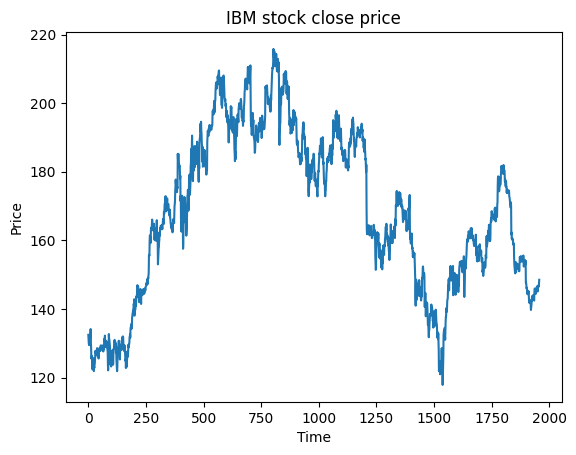

In [38]:
# Plot the data
npdata = data.to_numpy()[:,1].astype(np.float32)
plt.plot(range(len(npdata)), npdata)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("IBM stock close price")
# scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
npdata = scaler.fit_transform(npdata.reshape(-1,1)).reshape(-1)
npdata


In [39]:
# Create train and test data
sample_size = len(npdata)
train_size = int(sample_size*0.8)
sequence_length = 20
sequence_data = []
for i in range(sample_size-sequence_length+1):
    sequence_data.append(npdata[i:i+sequence_length])
sequence_data = np.stack(sequence_data)
# Split into train and test
sequence_data = torch.from_numpy(sequence_data).unsqueeze(dim=2)
x_train = sequence_data[:train_size,:,:]
y_train = sequence_data[1:train_size+1,:,:]
x_test = sequence_data[train_size:-1,:,:]
y_test = sequence_data[train_size+1:,:,:]
print(f"Train size {x_train.size()} {y_train.size()}\nTest size {x_test.size()} {y_test.size()}")

Train size torch.Size([1565, 20, 1]) torch.Size([1565, 20, 1])
Test size torch.Size([372, 20, 1]) torch.Size([372, 20, 1])


In [40]:
train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=100,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test,
                                          batch_size=100,
                                          shuffle=False)

# LSTM network

In [41]:
class LSTM(nn.Module):
    def __init__(self, input_feature, hidden_feature, output_feature):
        super().__init__()
        self.input_feature=hidden_feature
        self.hidden_feature=hidden_feature
        # Project the input_feature to hidden_feature
        self.input_projection = nn.Linear(input_feature, hidden_feature)
        # input gate
        self.weight_input_input = nn.Parameter(torch.Tensor(hidden_feature, hidden_feature))
        self.weight_hidden_input = nn.Parameter(torch.Tensor(hidden_feature, hidden_feature))
        self.bias_input = nn.Parameter(torch.Tensor(hidden_feature))
        # forget gate
        self.weight_input_forget = nn.Parameter(torch.Tensor(hidden_feature, hidden_feature))
        self.weight_hidden_forget = nn.Parameter(torch.Tensor(hidden_feature, hidden_feature))
        self.bias_forget = nn.Parameter(torch.Tensor(hidden_feature))
        # output gate
        self.weight_input_output = nn.Parameter(torch.Tensor(hidden_feature, hidden_feature))
        self.weight_hidden_output = nn.Parameter(torch.Tensor(hidden_feature, hidden_feature))
        self.bias_output = nn.Parameter(torch.Tensor(hidden_feature))
        # input data
        self.weight_input_data = nn.Parameter(torch.Tensor(hidden_feature, hidden_feature))
        self.weight_hidden_data = nn.Parameter(torch.Tensor(hidden_feature, hidden_feature))
        self.bias_data = nn.Parameter(torch.Tensor(hidden_feature))
        # Project the hidden_feature to output_feature
        self.ouput_projection = nn.Linear(hidden_feature, output_feature)

        self.init_weights()

    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self, x, previous_hidden_cell_states = None) :
        """Assumes x is of shape (batch, sequence, feature)"""
        sample_size, sequence_size, _ = x.size()
        hidden_seq = []

        if previous_hidden_cell_states is None:
            h_t, c_t = torch.zeros(self.hidden_feature).to(x.device), torch.zeros(self.hidden_feature).to(x.device)
        else:
            h_t, c_t = previous_hidden_cell_states

        for t in range(sequence_size): # iterate over the time steps
            x_t = x[:, t, :]
            x_t = self.input_projection(x_t)
            i_t = torch.sigmoid(x_t@self.weight_input_input + h_t@self.weight_hidden_input + self.bias_input)
            f_t = torch.sigmoid(x_t@self.weight_input_forget + h_t@self.weight_hidden_forget + self.bias_forget)
            g_t = torch.tanh(x_t@self.weight_input_data + h_t@self.weight_hidden_data + self.bias_data)
            o_t = torch.sigmoid(x_t@self.weight_input_output + h_t@self.weight_hidden_output + self.bias_output)
            c_t = c_t * f_t + g_t * i_t
            h_t = torch.tanh(c_t) * o_t
            output = self.ouput_projection(h_t)
            hidden_seq.append(output.unsqueeze(1))

        hidden_seq = torch.cat(hidden_seq, dim=1)
        return hidden_seq, (h_t, c_t)

input_feature=3
hidden_feature=7
output_feature=3
x = torch.rand((100, 10, input_feature))
test = LSTM(input_feature, hidden_feature, output_feature)
print(test(x)[0].size())
print(test(x)[1][0].size())
print(test(x)[1][1].size())
y = torch.rand((100, hidden_feature))
z = torch.rand((100, hidden_feature))
print(test(x, (y,z))[0].size())


torch.Size([100, 10, 3])
torch.Size([100, 7])
torch.Size([100, 7])
torch.Size([100, 10, 3])


In [42]:
input_feature = 1
hidden_feature = 32
output_feature = 1
model = LSTM(input_feature, hidden_feature, output_feature)
beta1 = 0.9
beta2 = 0.999
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(beta1, beta2))
loss_function = nn.MSELoss()
net = Model_Wrapper(model, optimizer, loss_function, device)
net.push_to_device()


In [43]:
net.train(20, train_loader)

Epoch: 1/20; Data 0/1565; Loss: 2.231920003890991
Epoch: 2/20; Data 0/1565; Loss: 0.07813715934753418
Epoch: 3/20; Data 0/1565; Loss: 0.4803812503814697
Epoch: 4/20; Data 0/1565; Loss: 0.12569180130958557
Epoch: 5/20; Data 0/1565; Loss: 0.818494975566864
Epoch: 6/20; Data 0/1565; Loss: 0.05014364793896675
Epoch: 7/20; Data 0/1565; Loss: 0.2575624883174896
Epoch: 8/20; Data 0/1565; Loss: 0.016038738191127777
Epoch: 9/20; Data 0/1565; Loss: 0.01564197987318039
Epoch: 10/20; Data 0/1565; Loss: 0.1264057606458664
Epoch: 11/20; Data 0/1565; Loss: 0.08574177324771881
Epoch: 12/20; Data 0/1565; Loss: 0.5143166780471802
Epoch: 13/20; Data 0/1565; Loss: 0.013811184093356133
Epoch: 14/20; Data 0/1565; Loss: 0.09589190781116486
Epoch: 15/20; Data 0/1565; Loss: 0.011676555499434471
Epoch: 16/20; Data 0/1565; Loss: 0.066253662109375
Epoch: 17/20; Data 0/1565; Loss: 0.02440503239631653
Epoch: 18/20; Data 0/1565; Loss: 0.14174272119998932
Epoch: 19/20; Data 0/1565; Loss: 0.03599094972014427
Epoch: 20

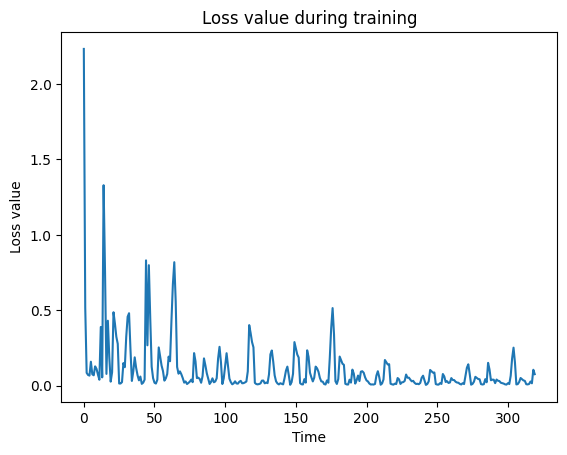

In [44]:
net.plot_train_loss()

In [45]:
net.test(test_loader)

Loss: 0.0457


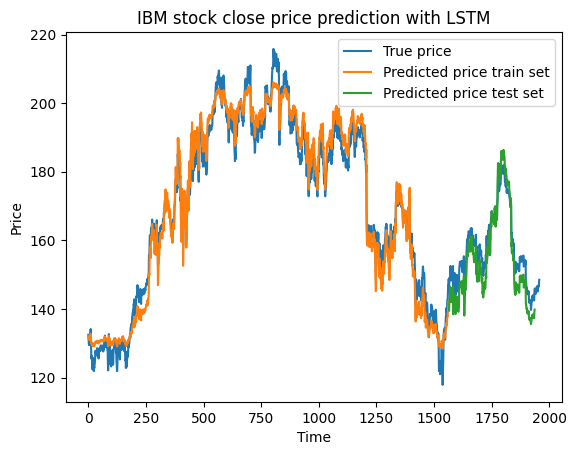

In [46]:
# Predict and convert the data
x_test.size()
y_pred_test, _ = net.model(x_test)
y_pred_train, _ = net.model(x_train)
def covert_sequence_back_to_data(x):
    result = x[:,0,:]
    scaler.inverse_transform(result)
    return result
x_test_plot = covert_sequence_back_to_data(x_test)
y_pred_test_plot = covert_sequence_back_to_data(y_pred_test.detach())
y_pred_train_plot = covert_sequence_back_to_data(y_pred_train.detach())

# Plot the data
train_size = int(sample_size*0.8)
plt.plot(range(len(npdata)), scaler.inverse_transform(npdata.reshape(-1, 1)), label = "True price")
plt.plot(range(len(y_pred_train_plot)), scaler.inverse_transform(y_pred_train_plot), label = "Predicted price train set")
plt.plot(range(train_size, train_size + len(y_pred_test_plot)), scaler.inverse_transform(y_pred_test_plot), label = "Predicted price test set")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("IBM stock close price prediction with LSTM")
plt.legend()

# GRU network

In [47]:
class GRU(nn.Module):
    def __init__(self, input_feature, hidden_feature, output_feature):
        super().__init__()
        self.input_feature=hidden_feature
        self.hidden_feature=hidden_feature
        # Project the input_feature to hidden_feature
        self.input_projection = nn.Linear(input_feature, hidden_feature)

        # reset gate
        self.weight_input_reset = nn.Parameter(torch.Tensor(hidden_feature, hidden_feature))
        self.weight_hidden_reset = nn.Parameter(torch.Tensor(hidden_feature, hidden_feature))
        self.bias_reset = nn.Parameter(torch.Tensor(hidden_feature))
        # update gate
        self.weight_input_update = nn.Parameter(torch.Tensor(hidden_feature, hidden_feature))
        self.weight_hidden_update = nn.Parameter(torch.Tensor(hidden_feature, hidden_feature))
        self.bias_update = nn.Parameter(torch.Tensor(hidden_feature))
        # update data
        self.weight_input_data = nn.Parameter(torch.Tensor(hidden_feature, hidden_feature))
        self.weight_hidden_data = nn.Parameter(torch.Tensor(hidden_feature, hidden_feature))
        self.bias_data = nn.Parameter(torch.Tensor(hidden_feature))

        # Project the hidden_feature to output_feature
        self.ouput_projection = nn.Linear(hidden_feature, output_feature)

        self.init_weights()

    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self, x, previous_hidden_states = None) :
        """Assumes x is of shape (batch, sequence, feature)"""
        sample_size, sequence_size, _ = x.size()
        hidden_seq = []

        if previous_hidden_states is None:
            h_t = torch.zeros(self.hidden_feature).to(x.device)
        else:
            h_t = previous_hidden_states

        for t in range(sequence_size): # iterate over the time steps
            x_t = x[:, t, :]
            x_t = self.input_projection(x_t)
            
            r_t = torch.sigmoid(x_t@self.weight_input_reset + h_t@self.weight_hidden_reset + self.bias_reset)
            u_t = torch.sigmoid(x_t@self.weight_input_update + h_t@self.weight_hidden_update + self.bias_update)
            
            d_t = torch.tanh(x_t@self.weight_input_data + (h_t*r_t)@self.weight_hidden_data + self.bias_data)
            
            h_t = h_t*(1-u_t) + d_t*u_t

            output = self.ouput_projection(h_t)
            hidden_seq.append(output.unsqueeze(1))

        hidden_seq = torch.cat(hidden_seq, dim=1)
        return hidden_seq, h_t

input_feature=3
hidden_feature=7
output_feature=3
x = torch.rand((100, 10, input_feature))
test = GRU(input_feature, hidden_feature, output_feature)
print(x.size())
print(test(x)[0].size())
print(test(x)[1][0].size())
print(test(x)[1][1].size())
y = torch.rand((100, hidden_feature))
z = torch.rand((100, hidden_feature))
print(test(x, y)[0].size())


torch.Size([100, 10, 3])
torch.Size([100, 10, 3])
torch.Size([7])
torch.Size([7])
torch.Size([100, 10, 3])


In [48]:
input_feature = 1
hidden_feature = 32
output_feature = 1
model = GRU(input_feature, hidden_feature, output_feature)
beta1 = 0.9
beta2 = 0.999
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(beta1, beta2))
loss_function = nn.MSELoss()
net = Model_Wrapper(model, optimizer, loss_function, device)
net.push_to_device()

In [49]:
net.train(20, train_loader)

Epoch: 1/20; Data 0/1565; Loss: 2.30934476852417
Epoch: 2/20; Data 0/1565; Loss: 0.020166458562016487
Epoch: 3/20; Data 0/1565; Loss: 0.021919583901762962
Epoch: 4/20; Data 0/1565; Loss: 0.013508534990251064
Epoch: 5/20; Data 0/1565; Loss: 0.011394217610359192
Epoch: 6/20; Data 0/1565; Loss: 0.12004800140857697
Epoch: 7/20; Data 0/1565; Loss: 0.1676100343465805
Epoch: 8/20; Data 0/1565; Loss: 0.8763806819915771
Epoch: 9/20; Data 0/1565; Loss: 0.11650754511356354
Epoch: 10/20; Data 0/1565; Loss: 0.028154853731393814
Epoch: 11/20; Data 0/1565; Loss: 0.12485536187887192
Epoch: 12/20; Data 0/1565; Loss: 0.008499275892972946
Epoch: 13/20; Data 0/1565; Loss: 0.01639905944466591
Epoch: 14/20; Data 0/1565; Loss: 0.04324622452259064
Epoch: 15/20; Data 0/1565; Loss: 0.051501959562301636
Epoch: 16/20; Data 0/1565; Loss: 0.3743303716182709
Epoch: 17/20; Data 0/1565; Loss: 0.016537675634026527
Epoch: 18/20; Data 0/1565; Loss: 0.3318139612674713
Epoch: 19/20; Data 0/1565; Loss: 0.008712314069271088


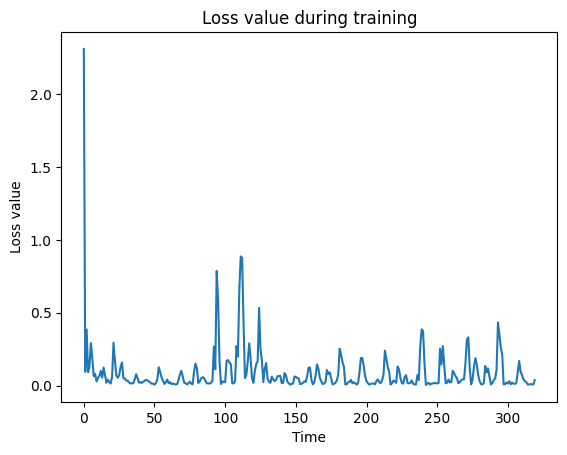

In [50]:
net.plot_train_loss()

In [51]:
net.test(test_loader)

Loss: 0.0095


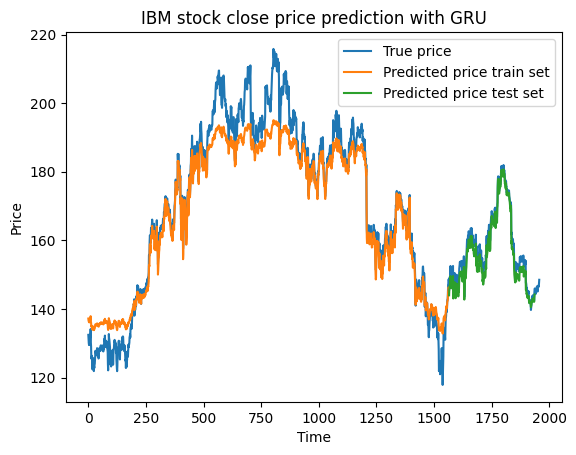

In [52]:
# Predict and convert the data
x_test.size()
y_pred_test, _ = net.model(x_test)
y_pred_train, _ = net.model(x_train)
def covert_sequence_back_to_data(x):
    result = x[:,0,:]
    scaler.inverse_transform(result)
    return result
x_test_plot = covert_sequence_back_to_data(x_test)
y_pred_test_plot = covert_sequence_back_to_data(y_pred_test.detach())
y_pred_train_plot = covert_sequence_back_to_data(y_pred_train.detach())

# Plot the data
train_size = int(sample_size*0.8)
plt.plot(range(len(npdata)), scaler.inverse_transform(npdata.reshape(-1, 1)), label = "True price")
plt.plot(range(len(y_pred_train_plot)), scaler.inverse_transform(y_pred_train_plot), label = "Predicted price train set")
plt.plot(range(train_size, train_size + len(y_pred_test_plot)), scaler.inverse_transform(y_pred_test_plot), label = "Predicted price test set")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("IBM stock close price prediction with GRU")
plt.legend()